<a href="https://colab.research.google.com/github/mofuoku417/Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Price-Using-Machine-Learning-Techniques/blob/main/Crude_PalmOil_Price_Prediction_using_Holt_Winters%2C_Arima%2C_MLP_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective
The objective of this python notebook is to use LSTM to predict monthly crude palm oil prices.



#### Data
The dataset is available at the following links:https://www.indexmundi.com/commodities/?commodity=palm-oil&months=300.

#### Mount Google Drive to Google Colab Notebook

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Use pip to install required packages: sklearn, pyramid and its flavors

In [2]:
!pip install sklearn
!pip install pyramid
!pip install pmdarima
!pip install pyramid-arima
!pip install pyramid.arima

     |████████████████████████████████| 246 kB 5.1 MB/s 
     |████████████████████████████████| 114 kB 62.4 MB/s 
     |████████████████████████████████| 251 kB 59.5 MB/s 
     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.5 MB 26.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 515 kB 5.1 MB/s 
  ERROR: Failed building wheel for pyramid-arima
  Running setup.py clean for pyramid-arima
Failed to build pyramid-arima
    Running setup.py install for pyramid-arima ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-s4ogunce/pyramid-arima_a42c944a3bea47778988971b2de690d1/setup.py'"'"'; __file__='"'"'/tmp/pip-install-s4ogunce/pyramid-arima_a42c944a3bea47778988971b2de

In [3]:
!pip uninstall statsmodels 
!pip install statsmodels

Found existing installation: statsmodels 0.12.2
Uninstalling statsmodels-0.12.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.12.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.12.2
  Using cached statsmodels-0.12.2-cp37-cp37m-manylinux1_x86_64.whl (9.5 MB)


#### Import the libraries:

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
import keras
import tensorflow
import statsmodels.tsa as sm 
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults, ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics import tsaplots
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Activation, Bidirectional, Flatten, TimeDistributed, SimpleRNN, Dropout, GRU, Input, Add, Multiply
from keras.layers.convolutional import Conv1D, MaxPooling1D
#from keras.layers.normalization import BatchNormalization
from keras import optimizers, initializers
from keras.regularizers import l2
from keras.initializers import TruncatedNormal, Constant, RandomNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from tensorflow.keras import optimizers
import plotly.express as px
optimizers.RMSprop()
import pickle
%matplotlib inline

In [4]:
validation_split = 0.25 

#### Create functions to compute the metrics

In [5]:
#Calculate the root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#Calculate the mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

#### Read in the crude palm oil monthly price to a data frame:

In [9]:
series = pd.read_csv('/content/gdrive/MyDrive/Univariate Crude Palm Oil Price Prediction/Data/crude_palmoil_price.csv')
date_rng = pd.date_range(start='1990-05-01', end='2020-04-01', freq='MS')

In [10]:
# convert the Month column to a datetime type and assign it back to the column
series.Month = pd.to_datetime(series.Month)

In [11]:
#Verify the 'datetime' column is a datetime64[ns] Dtype:
print(series.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Month    360 non-null    datetime64[ns]
 1   cpo_pri  360 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB
None


In [12]:
series['Month'] = pd.DataFrame(date_rng, columns=['Month'])

In [13]:
series.set_index('Month', inplace=True)

In [14]:
series.head().dropna()

,cpo_pri
Month,
1990-05-01,281
1990-06-01,272
1990-07-01,279
1990-08-01,291
1990-09-01,284


In [45]:
#Save the series dataframe
series = pd.read_csv('/content/gdrive/MyDrive/Univariate Crude Palm Oil Price Prediction/Data/series.csv')

FileNotFoundError: ignored

#### Interactive plot of the time series data

In [15]:
fig = px.line(series, x = series.index, y="cpo_pri", title = 'Monthly crude palm oil price from 1991 - 2020')
fig.show()

#### Decompose the time-series into its harmonic components
##### Additive seasonal decomposition

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



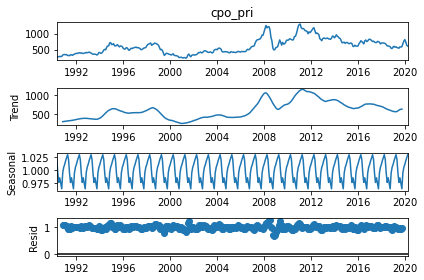

In [16]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(series.cpo_pri, model='multiplicative', freq=12) # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

### Train Test Split

In [17]:
train_len = 270
train = series[0:train_len] 
test = series[train_len:] 

### Moving Averages
#### Simple Moving Average

In [18]:
series.head()

,cpo_pri
Month,
1990-05-01,281
1990-06-01,272
1990-07-01,279
1990-08-01,291
1990-09-01,284


In [17]:
series.dropna(inplace=True)

In [18]:
series['6-month-SMA'] = series['cpo_pri'].rolling(window=6).mean()

In [19]:
series['12-month-SMA'] = series['cpo_pri'].rolling(window=12).mean()

####Plot

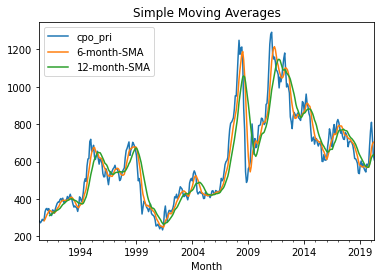

In [20]:
series.plot(title='Simple Moving Averages');

In [21]:
series.head(14) 

,cpo_pri,6-month-SMA,12-month-SMA
Month,,,
1990-05-01,281,NaN,NaN
1990-06-01,272,NaN,NaN
1990-07-01,279,NaN,NaN
1990-08-01,291,NaN,NaN
1990-09-01,284,NaN,NaN
1990-10-01,290,282.833333,NaN
1990-11-01,331,291.166667,NaN
1990-12-01,346,303.500000,NaN
1991-01-01,349,315.166667,NaN


### EWMA - Exponentially Weighted Moving Average

In [22]:
series.head()

,cpo_pri,6-month-SMA,12-month-SMA
Month,,,
1990-05-01,281,NaN,NaN
1990-06-01,272,NaN,NaN
1990-07-01,279,NaN,NaN
1990-08-01,291,NaN,NaN
1990-09-01,284,NaN,NaN


In [23]:
series['ewma12'] = series['cpo_pri'].ewm(span=12,adjust=False).mean()

####Plot

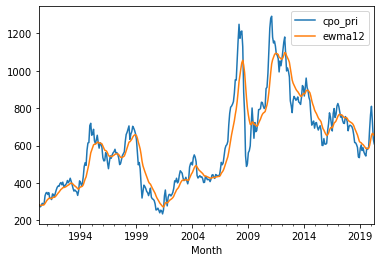

In [24]:
series[['cpo_pri','ewma12']].plot();

#### Compare the SMA to EWMA

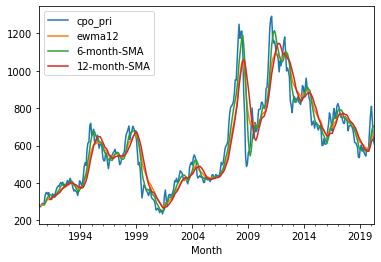

In [25]:
series[['cpo_pri','ewma12','6-month-SMA','12-month-SMA']].plot();

### Holt Winters - Simple, Double and Triple Exponential Smoothing

In [26]:
# set the span and the smoothing factor alpha
span = 12
alpha = 2/(span+1)

In [27]:
series.columns

Index(['cpo_pri', '6-month-SMA', '12-month-SMA', 'ewma12'], dtype='object')

In [28]:
# Set the frequency of the date time index as Monthly start as indicated by the data
series.index.freq = 'MS' 

In [29]:
series.head()

,cpo_pri,6-month-SMA,12-month-SMA,ewma12
Month,,,,
1990-05-01,281,NaN,NaN,281.000000
1990-06-01,272,NaN,NaN,279.615385
1990-07-01,279,NaN,NaN,279.520710
1990-08-01,291,NaN,NaN,281.286755
1990-09-01,284,NaN,NaN,281.704177


#### Simple Exponential Smoothing - Using Holt Winters

In [30]:
series['SES12'] = SimpleExpSmoothing(series['cpo_pri']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



In [32]:
series.head()

,cpo_pri,6-month-SMA,12-month-SMA,ewma12,SES12
Month,,,,,
1990-05-01,281,NaN,NaN,281.000000,281.000000
1990-06-01,272,NaN,NaN,279.615385,279.615385
1990-07-01,279,NaN,NaN,279.520710,279.520710
1990-08-01,291,NaN,NaN,281.286755,281.286755
1990-09-01,284,NaN,NaN,281.704177,281.704177


####Plot

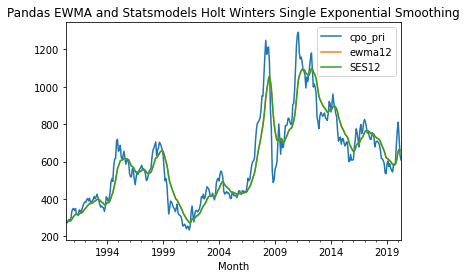

In [33]:
series[['cpo_pri','ewma12','SES12']].plot(title='Pandas EWMA and Statsmodels Holt Winters Single Exponential Smoothing');

####Double Exponential Smoothing

In [34]:
series['DES12'] = ExponentialSmoothing(series['cpo_pri'],trend='add').fit().fittedvalues.shift(-1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



####Plot

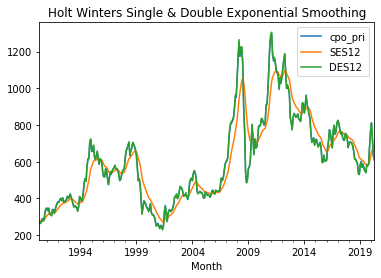

In [35]:
series[['cpo_pri','SES12','DES12']].plot(title='Holt Winters Single & Double Exponential Smoothing');

####Let's plot for the last 90 months.

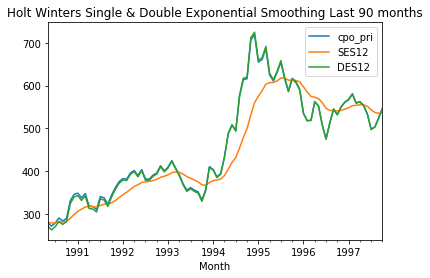

In [36]:
series[['cpo_pri','SES12','DES12']].iloc[:90].plot(title='Holt Winters Single & Double Exponential Smoothing Last 90 months').autoscale(axis='x',tight=True);

####Replot the above using the multiplicative adjustment instead of additive.

In [37]:
series['DES12_mul'] = ExponentialSmoothing(series['cpo_pri'],trend='mul').fit().fittedvalues.shift(-1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning:

overflow encountered in matmul



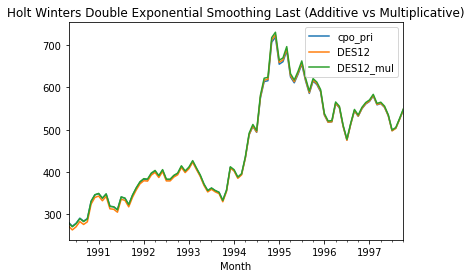

In [38]:
series[['cpo_pri','DES12','DES12_mul']].iloc[:90].plot(title='Holt Winters Double Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True);


###Triple Exponential Smoothing

In [39]:
series['TESadd12'] = ExponentialSmoothing(series['cpo_pri'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



In [40]:
series.head()

,cpo_pri,6-month-SMA,12-month-SMA,ewma12,SES12,DES12,DES12_mul,TESadd12
Month,,,,,,,,
1990-05-01,281,NaN,NaN,281.000000,281.000000,272.167148,279.704864,305.364266
1990-06-01,272,NaN,NaN,279.615385,279.615385,263.209044,270.615220,252.465294
1990-07-01,279,NaN,NaN,279.520710,279.520710,270.501478,277.701240,252.236061
1990-08-01,291,NaN,NaN,281.286755,281.286755,282.961132,289.949653,277.042818
1990-09-01,284,NaN,NaN,281.704177,281.704177,276.082919,282.932326,282.064876


In [41]:
series['TESmul12'] = ExponentialSmoothing(series['cpo_pri'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning:

overflow encountered in matmul



####Plot

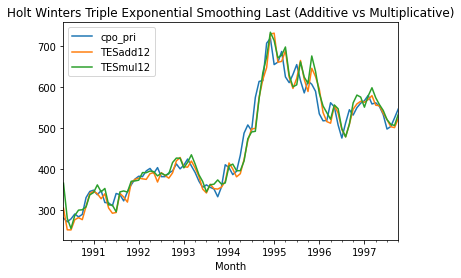

In [42]:
series[['cpo_pri','TESadd12','TESmul12']].iloc[:90].plot(title='Holt Winters Triple Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True);

###Split into training and test set:

In [19]:
train_len = 270
train = series[0:train_len] 
test = series[train_len:] 

###Holt's exponential smoothing method

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
Holt_pred = test.copy()
Holt_model = ExponentialSmoothing(np.asarray(train['cpo_pri']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
Holt_model_fit = Holt_model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(Holt_model_fit.params)
Holt_pred['holt_forecast'] = Holt_model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 281.0, 'initial_trend': -9.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead



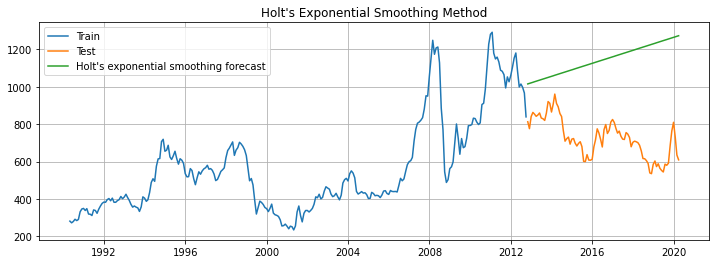

In [22]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot( train['cpo_pri'], label='Train')
plt.plot(test['cpo_pri'], label='Test')
plt.plot(Holt_pred['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

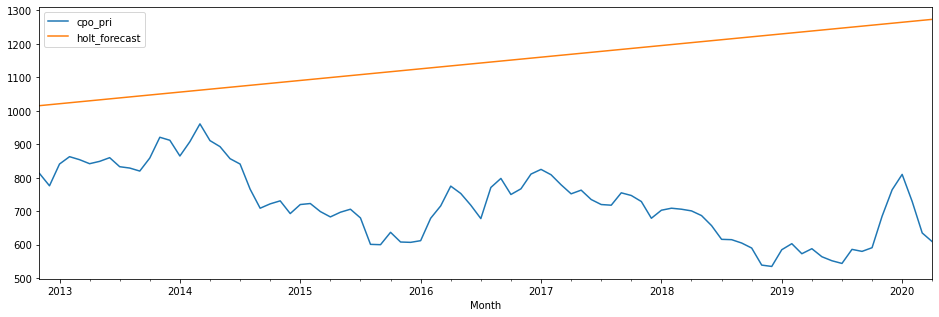

In [23]:
test['cpo_pri'].plot(figsize = (16,5), legend=True)
Holt_pred['holt_forecast'].plot(legend = True);

#### Compute the metrics for the Holt model

In [24]:
rmse_Holt = RMSE(test['cpo_pri'], Holt_pred['holt_forecast']).round(2)
mape_Holt = np.round(np.mean(np.abs(test['cpo_pri']-Holt_pred['holt_forecast'])/test['cpo_pri'])*100,2)
Metrics = {"RMSE_HOLT": rmse_Holt, "MAPE_HOLT": mape_Holt}
Metrics

{'MAPE_HOLT': 62.36, 'RMSE_HOLT': 451.14}

###Holt Winters' additive method with trend and seasonality

In [26]:
HoltAdd_pred = test.copy()
HoltAdd_model = ExponentialSmoothing(np.asarray(train['cpo_pri']) ,seasonal_periods=12 ,trend='add', seasonal='add')
HoltAdd_model_fit = HoltAdd_model.fit(optimized=True)
print(HoltAdd_model_fit.params)
HoltAdd_pred['hw_forecast'] = HoltAdd_model_fit.forecast(90)

{'smoothing_level': 0.9369729377662601, 'smoothing_trend': 0.029338968666827815, 'smoothing_seasonal': 0.06292117529441471, 'damping_trend': nan, 'initial_level': 575.4747410971698, 'initial_trend': -0.2750814307845797, 'initial_seasons': array([-256.09452033, -285.42397833, -299.59440307, -293.58364878,
       -291.65173999, -289.30914363, -259.86968629, -242.03734705,
       -241.43926492, -241.400176  , -257.65649896, -253.59314308]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



In [42]:
HoltAdd_pred['hw_forecast'] 

Month
2012-11-01    884.043591
2012-12-01    897.796621
2013-01-01    906.764162
2013-02-01    907.919075
2013-03-01    901.367118
                 ...    
2019-12-01    842.322400
2020-01-01    851.289941
2020-02-01    852.444854
2020-03-01    845.892897
2020-04-01    842.902731
Name: hw_forecast, Length: 90, dtype: float64

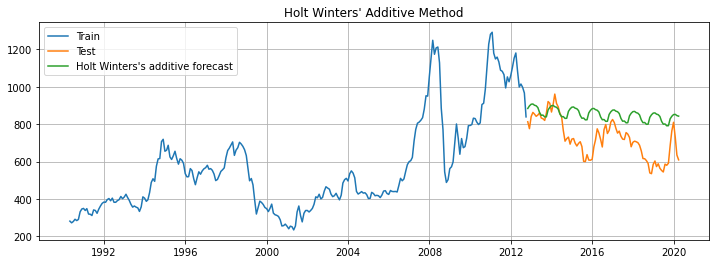

In [27]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot( train['cpo_pri'], label='Train')
plt.plot(test['cpo_pri'], label='Test')
plt.plot(HoltAdd_pred['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

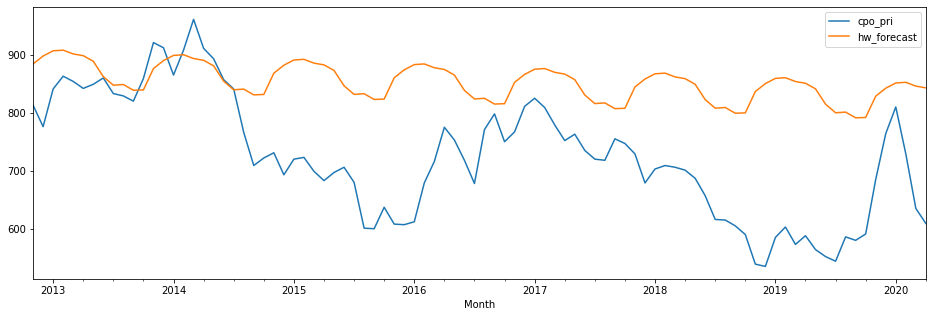

In [28]:
test['cpo_pri'].plot(figsize = (16,5), legend=True)
HoltAdd_pred['hw_forecast'].plot(legend = True);

####Compute the metrics for the Holt Winters' additive method

In [29]:
Metrics['RMSE_HoltAdd'] = RMSE(test['cpo_pri'], HoltAdd_pred['hw_forecast']).round(2)
Metrics['MAPE_HoltAdd'] = MAPE(test['cpo_pri'], HoltAdd_pred['hw_forecast'])
Metrics

{'MAPE_HOLT': 62.36,
 'MAPE_HoltAdd': 20.31209114238286,
 'RMSE_HOLT': 451.14,
 'RMSE_HoltAdd': 157.0}

###Holt Winter's multiplicative method with trend and seasonality

In [30]:
HoltM_pred = test.copy()
HoltM_model = ExponentialSmoothing(np.asarray(train['cpo_pri']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
HoltM_model_fit = HoltM_model.fit(optimized=True)
print(HoltM_model_fit.params)
HoltM_pred['hw_forecast'] = HoltM_model_fit.forecast(90)

{'smoothing_level': 0.8535706853876872, 'smoothing_trend': 0.00010088542449257364, 'smoothing_seasonal': 0.1464291371566676, 'damping_trend': nan, 'initial_level': 578.086762275226, 'initial_trend': 3.8118366551077028, 'initial_seasons': array([0.60276948, 0.54945146, 0.52900663, 0.54873846, 0.56528242,
       0.56891609, 0.60371394, 0.62164061, 0.61610448, 0.61272219,
       0.61853476, 0.61409292]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



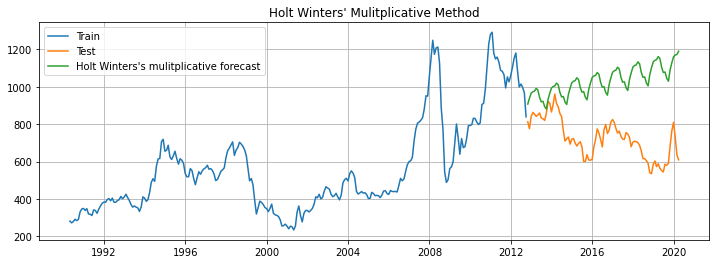

In [31]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot( train['cpo_pri'], label='Train')
plt.plot(test['cpo_pri'], label='Test')
plt.plot(HoltM_pred['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

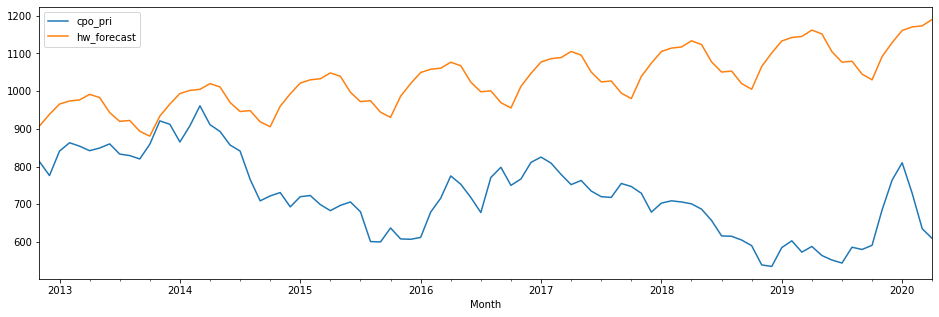

In [32]:
test['cpo_pri'].plot(figsize = (16,5), legend=True)
HoltM_pred['hw_forecast'].plot(legend = True);

####Compute the metrics for the Holt-Winters multiplicative method

In [33]:
Metrics['RMSE_HoltM'] = RMSE(test['cpo_pri'], HoltM_pred['hw_forecast']).round(2)
Metrics['MAPE_HoltM'] = MAPE(test['cpo_pri'], HoltM_pred['hw_forecast'])
Metrics

{'MAPE_HOLT': 62.36,
 'MAPE_HoltAdd': 20.31209114238286,
 'MAPE_HoltM': 45.970791697217116,
 'RMSE_HOLT': 451.14,
 'RMSE_HoltAdd': 157.0,
 'RMSE_HoltM': 341.66}

####Inference
##### Based on the RMSE values the Holt-Winters additive method is better

In [35]:
Metrics_1 = pd.DataFrame(Metrics.items(), columns=['RMSE|MAPE', 'Output'])

In [36]:
Metrics_1

,RMSE|MAPE,Output
0,RMSE_HOLT,451.140000
1,MAPE_HOLT,62.360000
2,RMSE_HoltAdd,157.000000
3,MAPE_HoltAdd,20.312091
4,RMSE_HoltM,341.660000
5,MAPE_HoltM,45.970792


####Scale Metrics_1 result

In [39]:
min_max_scaler = MinMaxScaler()
Metrics_1[["Output"]] = min_max_scaler.fit_transform(Metrics_1[["Output"]])
print(Metrics_1)

      RMSE|MAPE    Output
0     RMSE_HOLT  1.000000
1     MAPE_HOLT  0.097598
2  RMSE_HoltAdd  0.317268
3  MAPE_HoltAdd  0.000000
4    RMSE_HoltM  0.745885
5    MAPE_HoltM  0.059557


###ARIMA

####Lets read the airline data again to have a fresh copy

In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame({"cpo_pri":scaler.fit_transform(np.array(series['cpo_pri']).reshape(len(series),1)).reshape(len(series),)}, index = series.index)

####Train Test Split:

In [41]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

####Plot the ACF and ADF

ADF test results: (-2.3688314757022395, 0.15072739203030028, 12, 347, {'1%': -3.449336554273722, '5%': -2.8699055166063085, '10%': -2.571226758215748}, -1289.360326018246)
High p-value of ADF test (0.15072739203030028) shows that we fail to reject null hypothesis. 
 Hence, the dataset is non-stationary.


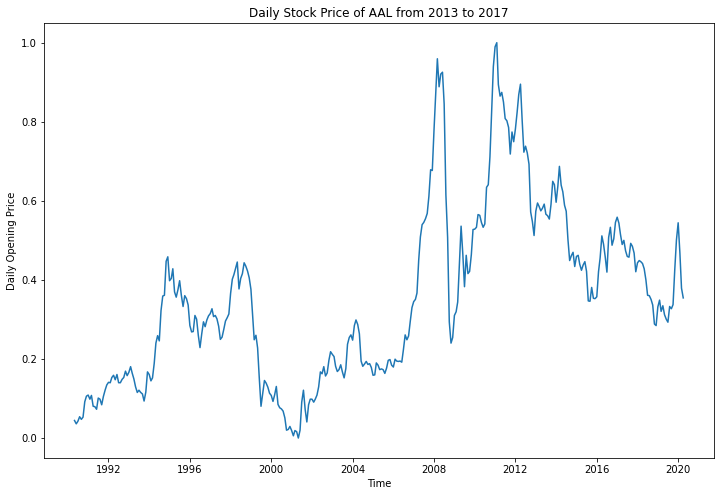

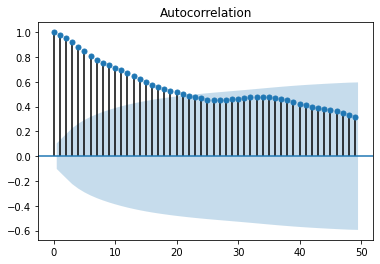

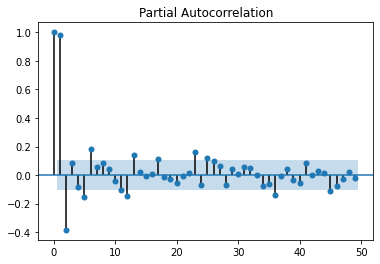

In [105]:
plt.figure(figsize=(12,8))
plt.plot(df)
plt.xlabel('Time')
plt.ylabel('Daily Opening Price')
plt.title('Daily Stock Price of AAL from 2013 to 2017')
plt.savefig('fig1.png', dpi=800, quality=95)
tsaplots.plot_acf(df, ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(df, ax=None, lags=np.arange(50), use_vlines=True)
print("ADF test results:", sm.stattools.adfuller(df.iloc[:,0], autolag='AIC'))
print('High p-value of ADF test ({}) shows that we fail to reject null hypothesis. \n Hence, the dataset is non-stationary.'.format(sm.stattools.adfuller(df.iloc[:,0], autolag='AIC')[1]))

#####The ACF and PACF graphs show a significant correlation between lags, so the data is not stationary. One method is to remove the trend by moving average and make it stationary for classical analysis. Manual decomposition of trend and seasonality: Use the smoothing method of moving average to remove the trend

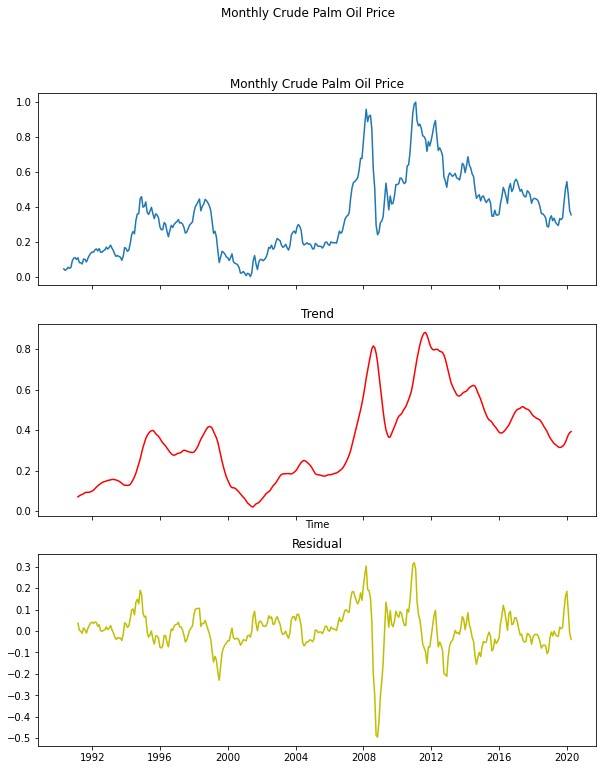

In [106]:
trendcomp = (df.rolling(10).mean()).rolling(2).mean()
res = (df - trendcomp).dropna()
noise = df.iloc[:,0] - trendcomp.iloc[:,0] 
df['trendcomp'] = trendcomp.values
df['noise'] = noise.values
fig = plt.figure(1, figsize=[10,12])
fig.suptitle('Monthly Crude Palm Oil Price')
fig1, fig2, fig4 = fig.subplots(nrows=3, ncols=1, sharex=True, sharey=False)
fig1.set_title('Monthly Crude Palm Oil Price')
fig2.set_title('Trend')
fig4.set_title('Residual')
fig2.set_xlabel('Time')
fig1.plot(df.loc[:,'cpo_pri'])
fig2.plot(df.loc[:,'trendcomp'], 'r')
fig4.plot(df.loc[:,'noise'], 'y')
fig.show()

#####Conduct autocorrelation on stationary residuals.

ADF test results: (-5.7858732182357295, 2.671409222619924e-08, 11, 338, {'1%': -2.572386540737369, '5%': -1.9418233204742512, '10%': -1.6160573005022572}, -1273.195035674204)
low p-value of ADF test (5.005649204887483e-07) Show that we reject the null hypothesis. So the residuals are almost stationary.
The P value of the ADF test (no constant, no trend) indicates that the data is stationary. So we can say that the data has a stationary trend.


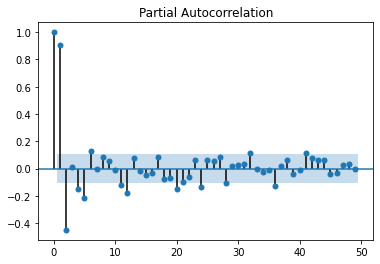

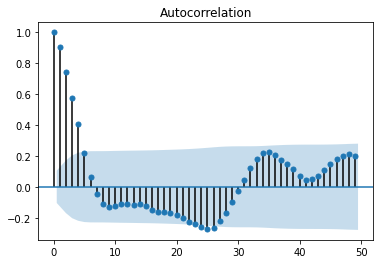

In [107]:
tsaplots.plot_pacf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_acf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
#ADF test on residual
print("ADF test results:", sm.stattools.adfuller(df.loc[:,'noise'].dropna(), regression='nc', autolag='AIC'))
print('low p-value of ADF test ({}) Show that we reject the null hypothesis. So the residuals are almost stationary.'.format(sm.stattools.adfuller(df.loc[:,'noise'].dropna(), autolag='AIC')[1]))
print('The P value of the ADF test (no constant, no trend) indicates that the data is stationary. So we can say that the data has a stationary trend.')

#####As we have seen, it is not easy to remove trend components through moving averages. Another way is to do differencing between data sets. Manually decompose seasonality and trend: Differencing method to see if the time series is difference stationary!


ADF test results: (-5.531998406074441, 9.012458570765537e-08, 11, 347, {'1%': -2.572213349998754, '5%': -1.9418012625316456, '10%': -1.6160765149191434}, -1282.8174198861775)
The low p-value of ADF test (9.012458570765537e-08) indicates that we will reject null hypothesis. 
 Hence, the residual is close to stationary.
Data is not getting stationary by multiple differencings. So data is trend stationary.


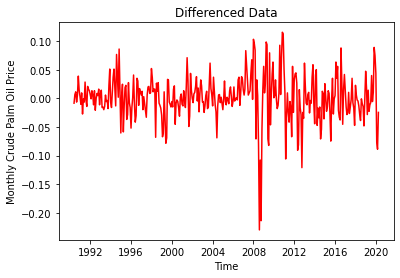

In [108]:
diff1 = df.loc[:,'cpo_pri'].diff(1)
nn = diff1.dropna()
plt.plot(nn,'r')
plt.title('Differenced Data')
plt.xlabel('Time')
plt.ylabel('Monthly Crude Palm Oil Price')

# ADF test on difference data:
print("ADF test results:", sm.stattools.adfuller(nn, regression='nc', autolag='AIC'))
print('The low p-value of ADF test ({}) indicates that we will reject null hypothesis. \n Hence, the residual is close to stationary.'.format(sm.stattools.adfuller(nn, regression='nc', autolag='AIC')[1]))
print('Data is not getting stationary by multiple differencings. So data is trend stationary.')

#### Find the best arima hyperparameters

In [111]:
# Fit auto_arima function to the crude palm oil price dataset
stepwise_fit = auto_arima(df_train['cpo_pri'] , start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)        
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-136.406, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-789.323, Time=1.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-451.447, Time=1.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-130.710, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-734.177, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-829.878, Time=4.22 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-874.460, Time=6.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=7.71 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=7.36 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=-197.364, Time=1.97 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.32 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=6.02 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=-479.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  270
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                 464.063
Date:                            Wed, 29 Sep 2021   AIC                           -914.126
Time:                                    01:33:19   BIC                           -889.255
Sample:                                         0   HQIC                          -904.125
                                            - 270                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0263      0.109      9.410      0.000       0.813       1.240
ar.L2         -0.0547      0.107     -0.513      0.608      -0.263       0.154
ma.L1          0.3601      0.101      3.559      0.000       0.162       0.558
ar.S.L12      -0.1044      0.069     -1.509      0.131      -0.240       0.031
ar.S.L24      -0.1679      0.066     -2.530      0.011      -0.298      -0.038
ma.S.L12      -0.8759      0.064    -13.767      0.000      -1.001      -0.751
sigma2         0.0015      0.000     14.450      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               366.33
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

####Inference

* The minimum AIC value was obtained by p=3, d=3, q=0 paramteres.
* SARIMA(2,0,1)x(2,1,1)12 will be chosen as the best model.


####Based on the results of the tests, specify the ARIMA model and fit it to the data:

####Fit a SARIMAX(2, 0, 1)x(2, 1, 1, 12) on the training set

In [112]:
arima_model = SARIMAX(df_train['cpo_pri'], 
                order = (2, 0, 1), 
                seasonal_order =(2, 1, 1, 12))
  
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            cpo_pri   No. Observations:                  270
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                 464.063
Date:                            Wed, 29 Sep 2021   AIC                           -914.126
Time:                                    01:39:43   BIC                           -889.255
Sample:                                05-01-1990   HQIC                          -904.125
                                     - 10-01-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0263      0.109      9.410      0.000       0.813       1.240
ar.L2         -0.0547      0.107     -0.513      0.608      -0.263       0.154
ma.L1          0.3601      0.101      3.559      0.000       0.162       0.558
ar.S.L12      -0.1044      0.069     -1.509      0.131      -0.240       0.031
ar.S.L24      -0.1679      0.066     -2.530      0.011      -0.298      -0.038
ma.S.L12      -0.8759      0.064    -13.767      0.000      -1.001      -0.751
sigma2         0.0015      0.000     14.450      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               366.33
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [113]:
arima_pred = arima_result.predict(start = len(df_train), end = len(df)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

2012-11-01    0.538434
2012-12-01    0.536513
2013-01-01    0.539612
2013-02-01    0.544695
2013-03-01    0.560933
                ...   
2019-12-01    0.496244
2020-01-01    0.511335
2020-02-01    0.523436
2020-03-01    0.529050
2020-04-01    0.534977
Freq: MS, Name: ARIMA_Predictions, Length: 90, dtype: float64

In [114]:
df_test['ARIMA_Predictions'] = arima_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



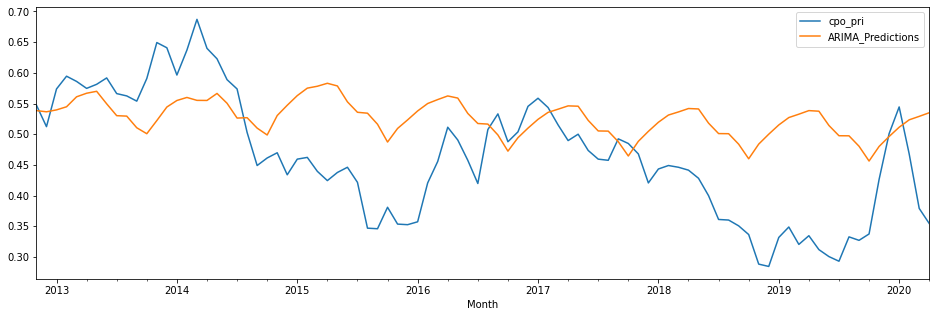

In [117]:
df_test['cpo_pri'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

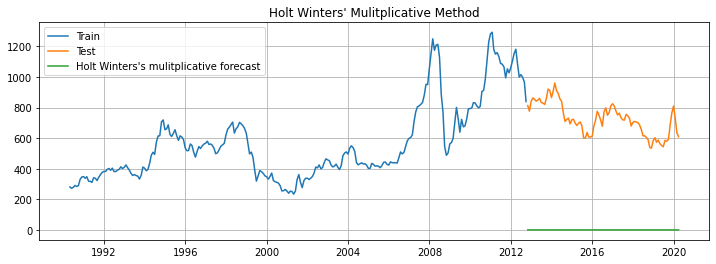

In [123]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot( train['cpo_pri'], label='Train')
plt.plot(test['cpo_pri'], label='Test')
plt.plot(df_forecasted_SARIMAX, label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

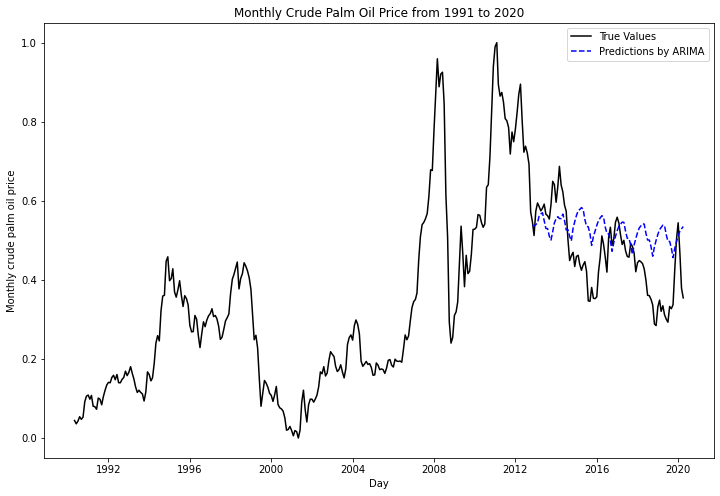

In [120]:
df_forecasted_SARIMAX = pd.DataFrame(index=df.index[math.floor(len(df)*trainfrac):].tolist(),data={'forecast':arima_pred})
plt.figure(figsize=(12,8))
plt.plot(df.loc[:,'cpo_pri'], 'k', df_forecasted_SARIMAX, 'b--')
plt.xlabel('Time')
plt.ylabel('Monthly crude palm oil price')
plt.title('Monthly Crude Palm Oil Price from 1991 to 2020')
plt.legend(['True Values', 'Predictions by ARIMA'], loc='best')
plt.show()

In [115]:
df_test['ARIMA_Predictions']

Month
2012-11-01    0.538434
2012-12-01    0.536513
2013-01-01    0.539612
2013-02-01    0.544695
2013-03-01    0.560933
                ...   
2019-12-01    0.496244
2020-01-01    0.511335
2020-02-01    0.523436
2020-03-01    0.529050
2020-04-01    0.534977
Name: ARIMA_Predictions, Length: 90, dtype: float64

In [116]:
arima_pred.values.reshape(-1,1)

array([[0.53843407],
       [0.53651332],
       [0.53961178],
       [0.54469494],
       [0.56093278],
       [0.56674427],
       [0.56991007],
       [0.54952231],
       [0.5301908 ],
       [0.52946293],
       [0.51047479],
       [0.50078688],
       [0.52221399],
       [0.54428839],
       [0.55492981],
       [0.55988004],
       [0.55513655],
       [0.55500917],
       [0.56642406],
       [0.55039391],
       [0.52629438],
       [0.52689305],
       [0.50991978],
       [0.49871638],
       [0.53041463],
       [0.54717455],
       [0.56286705],
       [0.57505285],
       [0.57813749],
       [0.58297649],
       [0.57861816],
       [0.55273644],
       [0.53572117],
       [0.53422543],
       [0.51622399],
       [0.48722601],
       [0.50935773],
       [0.52333263],
       [0.53789963],
       [0.55000054],
       [0.55641912],
       [0.56234644],
       [0.55884079],
       [0.53382926],
       [0.51743138],
       [0.51647114],
       [0.49876212],
       [0.472

#### Compute the metrics for the ARIMA model

In [ ]:
Metrics['RMSE_arima'] = RMSE(test['cpo_pri'], HoltM_pred['hw_forecast']).round(2)
Metrics['MAPE_HoltM'] = MAPE(test['cpo_pri'], HoltM_pred['hw_forecast'])
Metrics

In [130]:
rmse_arima = RMSE(df_test['cpo_pri'], arima_pred)
mape_arima = MAPE(df_test['cpo_pri'], rmse_arima )
Metrics = {"RMSE_ARIMA": rmse_arima, "MAPE_ARIMA": mape_arima}
Metrics

{'MAPE_ARIMA': 75.15894365505515, 'RMSE_ARIMA': 0.10984259051787651}

## Application of deep learning to the Crude Palm Oil Data

#### Prepare the dataset

In [131]:
#this function generates the input output
def input_output_generator(z,n):
    #generate the input output sets for mlp models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

#### Build the models and tune the parameters:

In [132]:
def Model_Build(Type,nodes,X_train, optimizer, learning_rate):
    # this function creates the model. Type is the type of deep learning model. It could be MLP, LSTM, ...
    # Nodes defines the sequence of nodes in different layers of network. It should be a list.
    # Optimizer and learning rate are used for compiling the model
    model = Sequential()
    if Type == 'MLP':
        model.add(Dense(nodes[0], activation='relu', input_shape=(X_train.shape[1],),
                        kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        for i in range(len(nodes)-1):
            model.add(Dense(nodes[i+1], activation='relu', kernel_initializer='random_uniform',
                            bias_initializer='RandomNormal'))

    if Type == 'LSTM':
        model.add(LSTM(nodes, activation='relu', kernel_initializer='RandomNormal',
                       input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
    
    if Type == 'Stacked Unidirectional LSTM':
        model.add(LSTM(nodes[0], activation='relu', kernel_initializer='random_uniform', 
                       bias_initializer='RandomNormal', return_sequences=True, input_shape=(X_train[1,:].shape)))
        for i in range(len(nodes)-1):
            retseq = True
            if (i+1) == (len(nodes)-1):
                retseq = False
            model.add(LSTM(nodes[i+1], activation='relu', kernel_initializer='random_uniform', 
                           bias_initializer='RandomNormal',return_sequences=retseq))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform',
                        bias_initializer='RandomNormal'))
    
    if Type == 'Bidirectional LSTM':
        model.add(Bidirectional(LSTM(nodes, activation='relu',
                                     kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                merge_mode='ave', input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
    
    if Type == 'Stacked Bidirectional LSTM':
        model.add(Bidirectional(LSTM(nodes[0], activation='relu', return_sequences=True,
                                    kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                merge_mode='ave', input_shape=(X_train[1,:].shape)))
        for i in range(len(nodes)-1):
            retseq = True
            if (i+1) == (len(nodes)-1):
                retseq = False
            model.add(Bidirectional(LSTM(nodes[i+1], activation='relu', return_sequences=retseq,
                                        kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                   merge_mode='ave'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform',
                       bias_initializer='RandomNormal'))
    
    if Type == 'SimpleRNN':
        if type(nodes) == int:
            model.add(SimpleRNN(nodes, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'tanh',
                               kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        else:
            model.add(SimpleRNN(nodes[0], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'tanh',
                                return_sequences=True, kernel_initializer='random_uniform', 
                                bias_initializer='RandomNormal'))
            for i in range(len(nodes)-1):
                retseq = True
                if (i+1) == (len(nodes)-1):
                    retseq = False
                model.add(SimpleRNN(nodes[i+1], activation='tanh', return_sequences=retseq, 
                                    kernel_initializer='random_uniform',bias_initializer='RandomNormal'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
    
    if Type == 'GRU':
        if type(nodes) == int:
            model.add(GRU(nodes, input_shape = (X_train.shape[1], X_train.shape[2]),
                          activation = 'tanh', return_sequences=False,
                         kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        else:
            model.add(GRU(nodes[0], input_shape = (X_train.shape[1], X_train.shape[2]),
                          activation = 'tanh', return_sequences=True,
                         kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
            for i in range(len(nodes)-1):
                retseq = True
                model.add(GRU(nodes[i+1], activation='tanh', return_sequences=retseq,
                             kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        #model.add(GRU(1, activation='tanh', return_sequences=False,
         #            kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform', bias_initializer='RandomNormal'))


    if optimizer == 'SGD':
        sgd = optimizers.SGD(lr=learning_rate, momentum=0)
        model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy', 'mse'])
    if optimizer == 'RMSprop':
        rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9)
        model.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['accuracy', 'mse'])
    if optimizer == 'Adagrad':
        adagrad = optimizers.Adagrad(lr=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adagrad, metrics=['accuracy', 'mse'])
    if optimizer == 'Adadelta':
        adadelta = optimizers.Adadelta(lr=learning_rate, rho=0.95)
        model.compile(loss='mean_squared_error', optimizer=adadelta, metrics=['accuracy', 'mse'])
    if optimizer == 'Adam':
        adam = optimizers.Adam(learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model


def Tune_epoch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this funciton tunes number of epochs of the model.
    e = [0 for i in range(len(epochs))]
    ii = 0
    for i in epochs:
        model = Model_Build(Type,nodes,X_train, optimizer, learning_rate)
        history_lstm = model.fit(X_train, Y_train, validation_split=val_split, epochs=i, batch_size=batch_size, verbose=0, shuffle=False)
        e[ii] = history_lstm.history['val_loss'][-1]
        ii += 1
    return e

def Tune_nodes(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes number of nodes.
    e = {}
    if np.size(np.shape(nodes)) == 1:
        for i in nodes:
            model = Model_Build(Type, i, X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    else:
        for i in range(np.shape(nodes)[0]):
            model = Model_Build(Type, nodes[i], X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    return e

def Tune_optimizer(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the optimizer and the learning rate.
    e = {}
    for i in range(len(optimizer)):
        for j in range(len(learning_rate)):
            model = Model_Build(Type, nodes, X_train, optimizer[i], learning_rate[j])
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[optimizer[i]+', rate='+str(learning_rate[j])] = history.history['val_loss'][-1]
    return e

def Tune_batch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the batch size.
    e = {}
    for i in batch_size:
        model = Model_Build(Type, nodes, X_train, optimizer, learning_rate)
        history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=i, verbose=0, shuffle=False)
        e[i] = history.history['val_loss'][-1]
    return e

### MLP

In [133]:
lag_mlp = 5 # lag is number of previous steps
X_train_mlp, Y_train_mlp, X_test_mlp, Y_test_mlp = input_output_generator(df['cpo_pri'].tolist(), lag_mlp)

In [134]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.01]
nodes = [64,32,8,1]
e = Tune_optimizer('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



{'Adagrad, rate=0.001': 0.46257129311561584,
 'Adagrad, rate=0.01': 0.23580242693424225,
 'Adam, rate=0.001': 0.46257129311561584,
 'Adam, rate=0.01': 0.46257129311561584}

In [135]:
# tuning number of layers and nodes in MLP 
#we will give few candidates for comparing
nodes = [[200,100,50,1],[64,32,16,1],[128,64,16,1]]
e = Tune_nodes('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



{0: 0.23347847163677216, 1: 0.23406894505023956, 2: 0.2348397672176361}

In [136]:
nodes_mlp = [200, 100, 50, 1]

In [137]:
#tune batch size
batch = [5, 10, 30]
e = Tune_batch('MLP', X_train_mlp, Y_train_mlp, nodes_mlp, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



#### Build the model

In [138]:
batch_size = 10
nodes_mlp = [100, 50, 20, 1]
optimizer = 'Adam'
learning_rate = 0.001

Epoch 1/200
20/20 [==============================] - 1s 11ms/step - loss: 0.0365 - accuracy: 0.0051 - mse: 0.0365 - val_loss: 0.3674 - val_accuracy: 0.0000e+00 - val_mse: 0.3674
Epoch 2/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 0.0051 - mse: 0.0221 - val_loss: 0.2475 - val_accuracy: 0.0000e+00 - val_mse: 0.2475
Epoch 3/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 0.0051 - mse: 0.0111 - val_loss: 0.1387 - val_accuracy: 0.0000e+00 - val_mse: 0.1387
Epoch 4/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0096 - accuracy: 0.0051 - mse: 0.0096 - val_loss: 0.1490 - val_accuracy: 0.0000e+00 - val_mse: 0.1490
Epoch 5/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0089 - accuracy: 0.0051 - mse: 0.0089 - val_loss: 0.1342 - val_accuracy: 0.0000e+00 - val_mse: 0.1342
Epoch 6/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0082 - accuracy: 0.0051 - mse: 0.0082 -

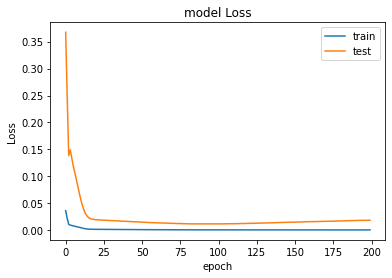

In [139]:
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, validation_split=validation_split, epochs=200,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/100
20/20 [==============================] - 1s 11ms/step - loss: 0.0409 - accuracy: 0.0051 - mse: 0.0409 - val_loss: 0.3943 - val_accuracy: 0.0000e+00 - val_mse: 0.3943
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0307 - accuracy: 0.0051 - mse: 0.0307 - val_loss: 0.3389 - val_accuracy: 0.0000e+00 - val_mse: 0.3389
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.0051 - mse: 0.0182 - val_loss: 0.2243 - val_accuracy: 0.0000e+00 - val_mse: 0.2243
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0103 - accuracy: 0.0051 - mse: 0.0103 - val_loss: 0.1388 - val_accuracy: 0.0000e+00 - val_mse: 0.1388
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0093 - accuracy: 0.0051 - mse: 0.0093 - val_loss: 0.1430 - val_accuracy: 0.0000e+00 - val_mse: 0.1430
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0087 - accuracy: 0.0051 - mse: 0.0087 -

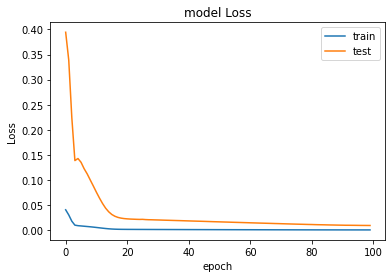

In [140]:
# 50 epochs are enough for training the model.
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, epochs=100,validation_split=validation_split,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### We do one-step ahead recursive forecasting. x_test provides real values to the model for predicting.

In [141]:
trainprediction_mlp = model_mlp.predict(X_train_mlp)
testprediction_mlp = model_mlp.predict(X_test_mlp)
trainprediction_mlp = pd.DataFrame(index=df.index[lag_mlp:len(df)-len(X_test_mlp)], data=trainprediction_mlp)
testprediction_mlp = pd.DataFrame(index=df.index[len(df)-len(X_test_mlp):], data=testprediction_mlp)

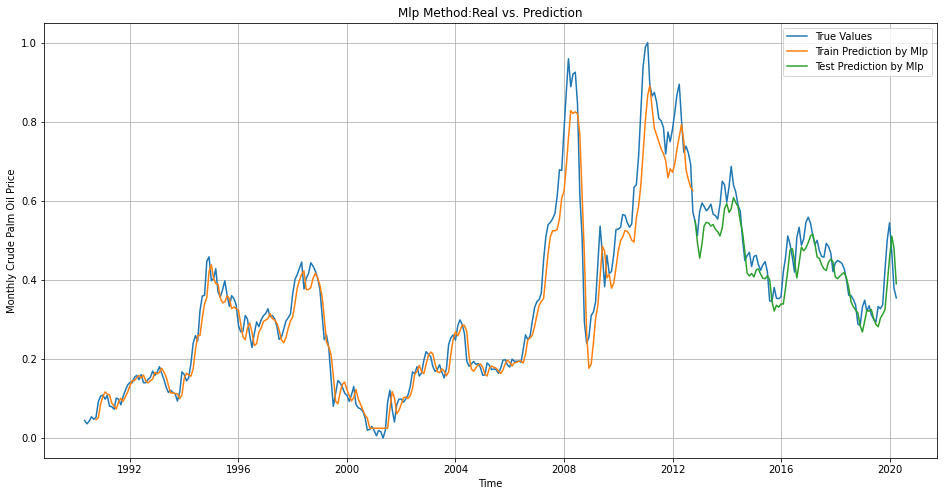

In [142]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df.index, df.cpo_pri, label = 'Train')
plt.plot(trainprediction_mlp,  label = 'Test')
plt.plot(testprediction_mlp,label = 'mlp forecast')
plt.legend(['True Values', 'Train Prediction by Mlp', 'Test Prediction by Mlp'],loc='best')
plt.title('Mlp Method:Real vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Time')
plt.show()

In [143]:
Metrics['RMSE_MLP'] = RMSE(Y_test_mlp, testprediction_mlp)
Metrics['MAPE_MLP'] = MAPE(Y_test_mlp, testprediction_mlp)
Metrics


{'MAPE_ARIMA': 75.15894365505515,
 'MAPE_MLP': 23.902620042106655,
 'RMSE_ARIMA': 0.10984259051787651,
 'RMSE_MLP': 0.04980336364902418}

#### LSTM

In [144]:
def input_output_generator_LSTM(z,n):
    #generating input output sets for LSTM models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_train_lstm = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
    x_test_lstm = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    return x_train_lstm, np.array(y_train), x_test_lstm, np.array(y_test)

In [145]:
lag_lstm = 3
X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = input_output_generator_LSTM(df['cpo_pri'].tolist(), lag_lstm)

In [146]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad', 'SGD', 'RMSprop', 'Adadelta']
lr = [0.001, 0.01, 0.1]
e = Tune_optimizer('Vanilla LSTM', X_train_lstm, Y_train_lstm, 50, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



{'Adadelta, rate=0.001': 0.01432804949581623,
 'Adadelta, rate=0.01': 0.01432804949581623,
 'Adadelta, rate=0.1': 0.01432804949581623,
 'Adagrad, rate=0.001': 0.01432804949581623,
 'Adagrad, rate=0.01': 0.01432804949581623,
 'Adagrad, rate=0.1': 0.01432804949581623,
 'Adam, rate=0.001': 0.01432804949581623,
 'Adam, rate=0.01': 0.01432804949581623,
 'Adam, rate=0.1': 0.01432804949581623,
 'RMSprop, rate=0.001': 0.01432804949581623,
 'RMSprop, rate=0.01': 0.01432804949581623,
 'RMSprop, rate=0.1': 0.01432804949581623,
 'SGD, rate=0.001': 0.01432804949581623,
 'SGD, rate=0.01': 0.01432804949581623,
 'SGD, rate=0.1': 0.01432804949581623}

#### Inference

In [147]:
# tuning number of nodes in LSTM layer
nodes = [1, 10, 50, 100, 200]
e = Tune_nodes('LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50, 10, optimizer, learning_rate)
nodes = int(min(e, key=e.get))

In [148]:
#tune batch size
batch = [1, 10, 30]
e = Tune_batch('LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50,
               batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

#### Build the LSTM model

In [149]:
nodes = 500    
batch_size= 20  
learning_rate = 0.01
optimizer = 'Adam'
model_lstm = Model_Build('LSTM', nodes, X_train_lstm, optimizer, learning_rate)
model_lstm.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 500)               1004000   
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 501       
Total params: 1,004,501
Trainable params: 1,004,501
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
10/10 [==============================] - 2s 66ms/step - loss: 0.0204 - accuracy: 0.0050 - mse: 0.0204 - val_loss: 0.3373 - val_accuracy: 0.0000e+00 - val_mse: 0.3373
Epoch 2/100
10/10 [==============================] - 0s 33ms/step - loss: 0.0215 - accuracy: 0.0050 - mse: 0.0215 - val_loss: 0.1372 - val_accuracy: 0.0000e+00 - val_mse: 0.1372
Epoch 3/100
10/10 [==============================] - 0s 38ms/step - loss: 0.0096 - accuracy: 0.0050 - mse: 0.0096 - val_loss: 0.1297 - val_accuracy: 0.0000e+00 - val_mse: 0.1297
Epoch 4/100
10/10 [==============================] - 0s 36ms/step - loss: 0.0106 - accuracy: 0.0050 - mse: 0.0106 - val_loss: 0.0822 - val_accuracy: 0.0149 - val_mse: 0.0822
Epoch 5/100
10/10 [==============================] - 0s 38ms/step - loss: 0.0059 - accuracy: 0.0050 - mse: 0.0059 - val_loss: 0.0678 - val_accuracy: 0.0149 - val_mse: 0.0678
Epoch 6/100
10/10 [==============================] - 0s 41ms/step - loss: 0.0041 - accuracy: 0.0050 - mse: 0.0041 - va

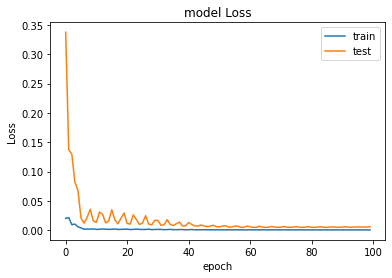

In [150]:
history_lstm = model_lstm.fit(X_train_lstm, Y_train_lstm, validation_split=validation_split, 
                              epochs=100, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### One-step ahead recursive forecasting:

In [151]:
trainprediction_lstm = model_lstm.predict(X_train_lstm)
testprediction_lstm = model_lstm.predict(X_test_lstm)
trainprediction_lstm = pd.DataFrame(index=df.index[lag_lstm:len(df)-len(X_test_lstm)], data=trainprediction_lstm)
testprediction_lstm = pd.DataFrame(index=df.index[len(df)-len(X_test_lstm):], data=testprediction_lstm)

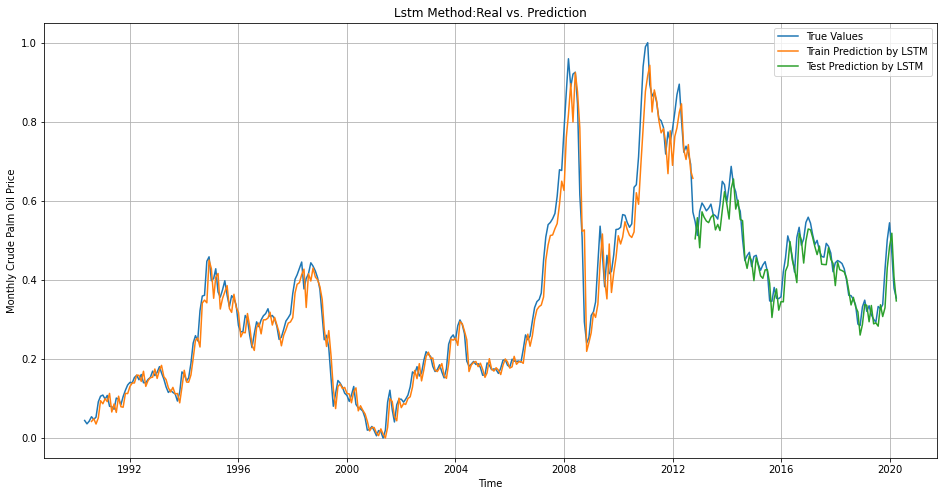

In [152]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df.index, df.cpo_pri, label = 'Train')
plt.plot(trainprediction_lstm,  label = 'Test')
plt.plot(testprediction_lstm,label = 'mlp forecast')
plt.legend(['True Values', 'Train Prediction by LSTM', 'Test Prediction by LSTM'],loc='best')
plt.title('Lstm Method:Real vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Time')
plt.show()

In [167]:
Metrics['RMSE_LSTM'] = RMSE(Y_test_lstm, testprediction_lstm)
Metrics['MAPE_LSTM'] = MAPE(Y_test_lstm, testprediction_lstm)
Metrics

{'MAPE_ARIMA': 75.15894365505515,
 'MAPE_LSTM': 24.600365223420688,
 'MAPE_MLP': 23.902620042106655,
 'RMSE_ARIMA': 0.10984259051787651,
 'RMSE_LSTM': 0.03824235171414216,
 'RMSE_MLP': 0.04980336364902418}

In [179]:
Metrics = [{'MAPE_ARIMA': 75.15894365505515,
 'MAPE_LSTM': 24.600365223420688,
 'MAPE_MLP': 23.902620042106655,
 'RMSE_ARIMA': 0.10984259051787651,
 'RMSE_LSTM': 0.03824235171414216,
 'RMSE_MLP': 0.04980336364902418}]

In [180]:
pd.DataFrame.from_dict(Metrics, orient='columns')

,MAPE_ARIMA,MAPE_LSTM,MAPE_MLP,RMSE_ARIMA,RMSE_LSTM,RMSE_MLP
0,75.158944,24.600365,23.90262,0.109843,0.038242,0.049803


In [178]:
pd.DataFrame.from_dict(Metrics, orient='columns')

ValueError: ignored

In [175]:
 pd.DataFrame(Metrics.items())

,0,1
0,RMSE_ARIMA,0.109843
1,MAPE_ARIMA,75.158944
2,RMSE_MLP,0.049803
3,MAPE_MLP,23.902620
4,RMSE_LSTM,0.038242
5,MAPE_LSTM,24.600365


In [177]:
pd.DataFrame(Metrics.items(), columns=['RMSE|MAPE', 'Output'])

,RMSE|MAPE,Output
0,RMSE_ARIMA,0.109843
1,MAPE_ARIMA,75.158944
2,RMSE_MLP,0.049803
3,MAPE_MLP,23.902620
4,RMSE_LSTM,0.038242
5,MAPE_LSTM,24.600365


In [173]:
my_dict = {'MAPE_ARIMA': 75.15894365505515,
 'MAPE_LSTM': 24.600365223420688,
 'MAPE_MLP': 23.902620042106655,
 'RMSE_ARIMA': 0.10984259051787651,
 'RMSE_LSTM': 0.03824235171414216,
 'RMSE_MLP': 0.04980336364902418}

In [174]:
print (my_dict)
print (type(my_dict))

{'MAPE_ARIMA': 75.15894365505515, 'MAPE_LSTM': 24.600365223420688, 'MAPE_MLP': 23.902620042106655, 'RMSE_ARIMA': 0.10984259051787651, 'RMSE_LSTM': 0.03824235171414216, 'RMSE_MLP': 0.04980336364902418}
<class 'dict'>


In [170]:
pd.DataFrame.from_dict(Metrics)

ValueError: ignored

#### Compare the models

In [154]:
series2 = series.loc['2012-11-01':'2020-04-01']

In [155]:
series2

,cpo_pri
Month,
2012-11-01,813
2012-12-01,776
2013-01-01,841
2013-02-01,863
2013-03-01,854
...,...
2019-12-01,764
2020-01-01,810
2020-02-01,729


In [156]:
#arima_predictions = arima_pred.values.reshape(-1,1)
#arima_predictions = scaler.inverse_transform(arima_predictions)
#arima_predictions

In [157]:
#arima_predictions = arima_pred.values.reshape(-1,1)
#arima_predictions = scaler.inverse_transform(arima_predictions)
#df_test['ARIMA_Predictions'] = arima_pred

#df_test['ARIMA_Predictions'] = arima_pred #########################
#arima_pred = scaler.inverse_transform(arima_pred)
#df_test['ARIMA_Predictions'] = arima_pred



######This parts works
arima_predictions = arima_pred.values.reshape(-1,1)
arima_predictions = scaler.inverse_transform(arima_predictions)
df_test['arima_predictions'] = arima_predictions
df_test['testprediction_mlp'] = testprediction_mlp #########################
mlp_predictions = scaler.inverse_transform(testprediction_mlp)
#df_test['mlp_predictions'] = mlp_predictions
lstm_predictions = scaler.inverse_transform(testprediction_lstm)
df_test['lstm_predictions'] = lstm_predictions
df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,cpo_pri,ARIMA_Predictions,arima_predictions,testprediction_mlp,lstm_predictions
Month,,,,,
2012-11-01,0.547259,0.538434,803.663251,0.549265,767.170410
2012-12-01,0.512287,0.536513,801.631087,0.495396,823.568787
2013-01-01,0.573724,0.539612,804.909268,0.455054,743.175903
2013-02-01,0.594518,0.544695,810.287251,0.491453,839.430481
2013-03-01,0.586011,0.560933,827.466878,0.536383,825.207825
...,...,...,...,...,...
2019-12-01,0.500945,0.496244,759.026058,0.388926,688.737427
2020-01-01,0.544423,0.511335,774.992762,0.455826,745.988403
2020-02-01,0.467864,0.523436,787.795106,0.510657,782.108398


In [158]:
df_test.head()

,cpo_pri,ARIMA_Predictions,arima_predictions,testprediction_mlp,lstm_predictions
Month,,,,,
2012-11-01,0.547259,0.538434,803.663251,0.549265,767.170410
2012-12-01,0.512287,0.536513,801.631087,0.495396,823.568787
2013-01-01,0.573724,0.539612,804.909268,0.455054,743.175903
2013-02-01,0.594518,0.544695,810.287251,0.491453,839.430481
2013-03-01,0.586011,0.560933,827.466878,0.536383,825.207825


In [160]:
#Remove unwanted columns
df_test = df_test.drop(columns=['ARIMA_Predictions', 'testprediction_mlp'])

In [161]:
df_test.head()

,cpo_pri,arima_predictions,lstm_predictions
Month,,,
2012-11-01,0.547259,803.663251,767.170410
2012-12-01,0.512287,801.631087,823.568787
2013-01-01,0.573724,804.909268,743.175903
2013-02-01,0.594518,810.287251,839.430481
2013-03-01,0.586011,827.466878,825.207825


In [ ]:
pd_data[["ScaledPrice"]] = scaler.fit_transform(pd_data[["Price"]])
  
print(pd_data)

In [ ]:
plt.figure(figsize=(16,9))
#plt.plot_date(test_data.index, test_data["cpo_pri"], linestyle="-")
plt.plot_date(test_data.index, test_data["arima_predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["mlp_predictions"], linestyle="--")
plt.plot_date(test_data.index, test_data["lstm_predictions"], linestyle=":")
plt.legend()
plt.show()

NameError: ignored

<Figure size 1152x648 with 0 Axes>

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Monthly beer production"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()